In [1]:
import numpy as np
import pandas as pd

from utils.utils import *
from utils.utils_baseline_svm import *

import matplotlib.pyplot as plt
%matplotlib inline

import csv

from sklearn.feature_extraction import DictVectorizer
from sklearn import svm

from collections import Counter, OrderedDict

from math import inf
from time import time

In [2]:
kwargs_lin_clf = nice_dict({'mk_chars': True, 
                            'char_filter': 2, 'allowed_chars': None, 
                            'mk_ngrams': True, 'ngram_width': 5, 
                            'ngram_filter': 2, 'allowed_ngrams': None, 
                            'keep_infreq_labels': False, 'label_count_thresh': 10, 
                            'valid_ratio': 0.0, 
                            })

kwargs_svm = nice_dict({'C': 0.10,  # penalty term
                        'decision_function_shape': 'ovr',  # one-vs-rest (‘ovr’) / one-vs-one (‘ovo’) 
                        'random_state': seed(), 
                        'kernel': 'linear', 
                        'gamma': 'auto' ,  # kernel coef for ‘rbf’, ‘poly’ and ‘sigmoid’. ‘auto’ -> 1/n_features
                        'probability': True,  # enable probability estimates 
                        'shrinking': True,  # use the shrinking heuristic 
                        'max_iter': -1  # -1 mean no limitation 
                        })

In [ ]:
def jaccard_sim(d1, d2):
    # collect union keys
    key_union = list(dict(d1, **d2))
    # for each key, get max(d1[key], d2[key]), with default of zero
    val_union = [max(d1.get(k, 0), d2.get(k, 0)) for k in key_union]
    # collect intersection keys
    key_intersect = [k for k in d1 if k in d2]
    # for each key, get min(d1[key], d2[key]), (with default of inf)
    val_intersect = [min(d1.get(k, inf), d2.get(k, inf)) for k in key_intersect]
    return float(sum(val_intersect) / sum(val_union))

In [ ]:
def labeld_unlabeled_similarities(*, sim_thereshold, 
                                  x_unlabeled, X_unlabeled, X_labeled, y):
    """
    Takes in the labeled, unlabeled data and the labels
    Returns sim_result_list, sim_dict_filtered, sim_dict,
    where sim_result_list,
    sim_dict_filtered,
    sim_dict is a dict from unlabeled text to (label, Jaccard sim) tuples for all labeled observations.
    """ 
    sim_dict = {}
    timenow = time()
    for text, features in zip(x_unlabeled, X_unlabeled):
        sim_dict[text] = [(y[i], jaccard_sim(obs, features)) for i, obs in enumerate(X_labeled)]

    print('Calculating all Jaccard similarities took {:.2f} seconds'.format(time() - timenow))
    
    # filtering out entries with similarity below threshold
    timenow = time()
    sim_dict_filtered = {}
    for k, v in sim_dict.items():
        sim_dict_filtered[k] = [(label, sim) for (label, sim) in v if sim >= sim_thereshold]
        # remove labels that don't meet the criteria
        if sim_dict_filtered[k] == []: del sim_dict_filtered[k]    
    print('Removing entries with Jaccard sim lower than the threshold took {:.2f} seconds'.
          format(time() - timenow))
    
    # return only the top result
    sim_result_list = []
    for k, v in sim_dict_filtered.items():
        for label, sim in v:
            # keep the entry with the highest similarity
            top_sim = 0
            if sim > top_sim:
                top_label, top_sim = label, sim
            sim_result_list.append([k, top_label, top_sim])
    
    return sim_result_list, sim_dict_filtered, sim_dict

In [ ]:
x, y, n, main_data = init_data()
x_unlabeled = main_data['FREETXT'][n:]
# removing text fields shorter than sliding window width
x_unlabeled = x_unlabeled.loc[[len(k) >= kwargs_lin_clf.ngram_width 
                               for k in x_unlabeled]]

### global counter: characters ###
if kwargs_lin_clf.mk_chars:
    char_counter = dict_addition([Counter(obs) for obs in x])
    allowed_chars = [key for key,value in char_counter.items() 
                     if value >= kwargs_lin_clf.char_filter]
    allowed_chars.sort()

    # replacing unknown characters with UNKNOWN symbol
    unknown_char = '<unk-char>'
    # for labeled x
    x_unk = [list(obs) for obs in x]
    x_unk = [[char if char in allowed_chars 
              else unknown_char for char in obs]
             for obs in x_unk]
    # for unlabeled x
    x_unk_unlabeled = [list(obs) for obs in x_unlabeled]
    x_unk_unlabeled = [[char if char in allowed_chars 
                        else unknown_char for char in obs]
                       for obs in x_unk_unlabeled]
else:
    allowed_chars = list({char for obs in x for char in obs})
    allowed_chars.sort()
    x_unk = x
    x_unk_unlabeled = x_unlabeled

### global counter: ngrams ###
if kwargs_lin_clf.mk_ngrams:
    ngram_counter = dict_addition(
        [Counter(join_sliding_window(obs, kwargs_lin_clf.ngram_width))
         for obs in x_unk])
    allowed_ngrams = [key for key,value in ngram_counter.items() 
                     if value >= kwargs_lin_clf.ngram_filter]
    allowed_ngrams.sort()
    
    ### apply ngrams ###
    unknown_ngram = '<unk-ngram>'
    x_unk = [obs + [ngram
                    if ngram in allowed_ngrams
                    else unknown_ngram
                    for ngram in join_sliding_window(obs, 
                        kwargs_lin_clf.ngram_width)]
             for obs in x_unk]
    x_unk_unlabeled = [obs + [ngram
                    if ngram in allowed_ngrams
                    else unknown_ngram
                    for ngram in join_sliding_window(obs, 
                        kwargs_lin_clf.ngram_width)]
             for obs in x_unk_unlabeled]
    
else:
    pass

X_labeled = [Counter(obs) for obs in x_unk]
X_unlabeled = [Counter(obs) for obs in x_unk_unlabeled]

In [ ]:
"""
Generate label suggestions, 
based on a SVM classifier.
"""

In [ ]:
for var in [y, X_labeled, X_unlabeled]:
    print(type(var), len(var), var[0])
    
# Counter([x for line in X_labeled for x in line])['<unk-char>']

In [ ]:
# using the train-validation split function
# to discard infrequent labels
_, x_train, _, y_train, _, _, _, statistics_dict = \
    train_validation_split(x=X_labeled, y=y, 
                           freq=[1 for elem in range(len(y))], 
                           label_count_thresh=kwargs_lin_clf.label_count_thresh, 
                           valid_ratio=kwargs_lin_clf.valid_ratio, 
                           keep_rare_labels=kwargs_lin_clf.keep_infreq_labels)

In [ ]:
# vectorizer transforms dict into sparse matrix
v = DictVectorizer(sparse=True)

# create a sparse X matrix with character and n-grams features
X_train = v.fit_transform(x_train)
X_unlabeled = v.transform(X_unlabeled)

In [ ]:
svm_clf = svm.SVC(**kwargs_svm)

# print(svm_clf)
svm_clf.fit(X_train, y_train)

In [ ]:
# array to hold log probabilities (takes a bit longer to calc)
pred_prob = svm_clf.predict_log_proba(X_unlabeled)
# makes y into array with the same shape as the log prob
y_train_dense = y_to_dense(y=y_train, 
                           classes=svm_clf.classes_)

In [ ]:
prob_threshold = 0.5
num_of_suggestions = sum(pred_prob.max(axis=1) >= np.log(prob_threshold))
print('There are {} suggestions made, with a confidence of at least {}'
      .format(num_of_suggestions, prob_threshold))
# There are 936 suggestions made, with a confidence of at least 0.5
print('Since this method appears to produce inferior results, it would not be investigated any further.')

In [ ]:
"""
Generate label suggestions, 
based on Jaccard similarities to labels data.
Skip the following block of code if file were already generated.
"""

In [ ]:
sim_result_list, sim_dict_filtered, sim_dict = \
    labeld_unlabeled_similarities(
        sim_thereshold=0.5, 
        x_unlabeled=x_unlabeled, 
        X_unlabeled=X_unlabeled, 
        X_labeled=X_labeled, 
        y=y)

# save to file (python pickle format)
for name, obj in [('sim_result_list', sim_result_list), 
                  ('sim_dict', sim_dict), 
                  ('sim_dict_filtered', sim_dict_filtered)]:
    save(name, obj)
#     print(name, str(obj))

In [3]:
"""
Load data from files, after files have been generated.
"""
sim_dict_filtered = load('sim_dict_filtered')

In [4]:
def get_filtered_suggestion_results(threshold, 
                                    sim_dict_filtered):
    """
    Inputs are threshold, a Jaccard similarity threshold
        and sim_dict_filtered, of the form {'text': [(label, similarity)]}.
    Returns some summaries regarding the label suggestions.
        text: the free text field.
        labels: the suggested labels.
        number_of_distinct_labels: self explaining.
        labels_sim_tup: retain the tuples in the raw form.
    """
    text = []
    labels = []
    number_of_distinct_labels = []
    labels_sim_tup = []

    for key,val in sim_dict_filtered.items():
        # val is a list of (label, sim) tuples

        if max({v[1] for v in val}) >= threshold:
#             print(key, len(
#                 {v[0] for v in val if v[1] >= thresh}))

            # add the free text
            text.append([key])
            # add the labels
            labels.append([v[0] for v in val 
                           if v[1] >= threshold])
            # count the number of distinct labels
            number_of_distinct_labels.append(
                len({v[0] for v in val 
                     if v[1] >= threshold}))
            # add the filtered tuples list
            labels_sim_tup.append([v for v in val 
                                   if v[1] >= threshold])
            
    return text, labels, \
           number_of_distinct_labels, \
           labels_sim_tup

        
def record_threshold_data(threshold, 
                          number_of_distinct_labels, 
                          labels_sim_tup):
        """
        A handling function to record summaries for each threshold.
        Is used to generate a Pandas DataFrame to analyze suggestions.
        """
        return OrderedDict((
            ('Threshold', threshold), 
            ('Mean # suggestions', 
             np.mean(number_of_distinct_labels)), 
            ('Max # suggestions', 
             max(number_of_distinct_labels)), 
            ('Mean similarity', 
           np.mean([[v[1] 
                     for tup in labels_sim_tup 
                     for v in tup]])), 
            ('Min similarity', 
             min([v[1] 
                  for tup in labels_sim_tup 
                  for v in tup])), 
          ('Unanimous suggestions', 
           len([l for l in number_of_distinct_labels 
                if l == 1])), 
            ('Unanimous mean similarity', 
             np.mean([tup[0][1] 
                      for tup, l 
                      in zip(labels_sim_tup, 
                             number_of_distinct_labels) 
                      if l == 1]))
        ))


In [5]:
label_suggestion_summary = []
for threshold in np.linspace(0.5,1.0, 51):
# for threshold in np.linspace(0.5,1.0, 3):
    _, _, number_of_distinct_labels, \
        labels_sim_tup = \
        get_filtered_suggestion_results(threshold, 
                                        sim_dict_filtered)
    label_suggestion_summary.append(
        record_threshold_data(
            threshold, 
            number_of_distinct_labels, 
            labels_sim_tup)        
        )

In [6]:
label_suggestion_summary =  \
    pd.DataFrame(label_suggestion_summary)
    
# some float formatting
label_suggestion_summary_formatted = \
    label_suggestion_summary.head(5).style.format(
        {'Mean # suggestions': '{:.2f}', 
         'Mean similarity': '{:.2f}', 
         'Min similarity': '{:.2f}', 
         'Unanimous mean similarity': '{:.2f}'})

In [7]:
# label_suggestion_summary.head(3)
label_suggestion_summary_formatted

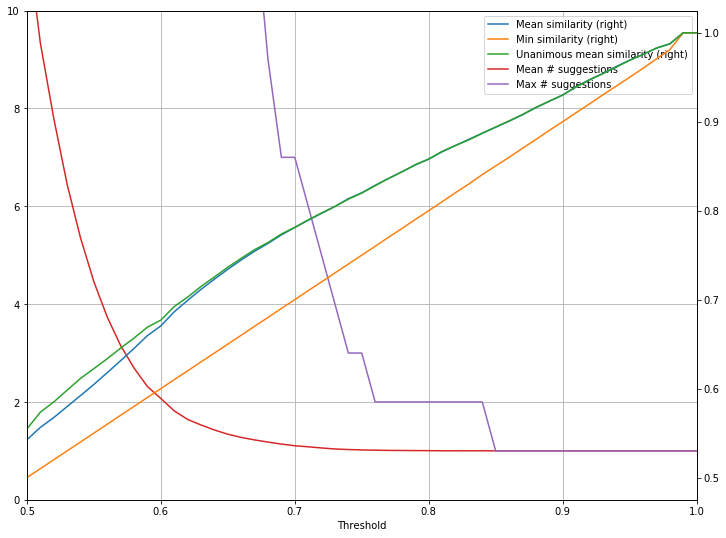

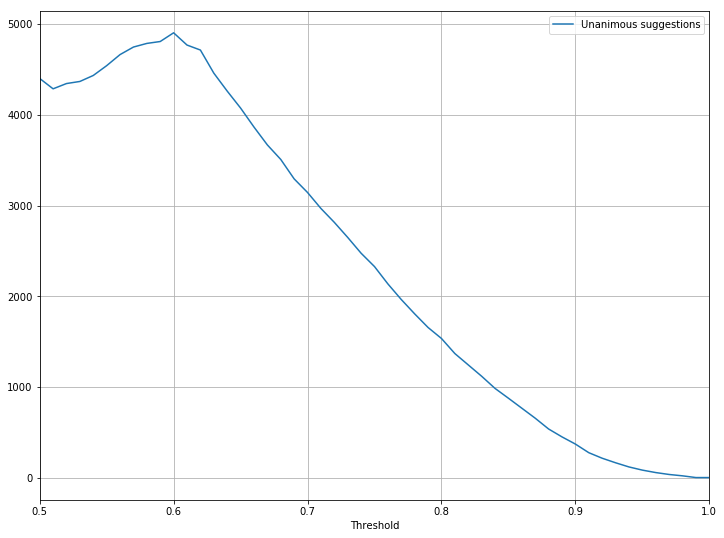

In [8]:
label_suggestion_summary.plot(x='Threshold', 
                              y=['Mean similarity', 
                                 'Min similarity', 
                                 'Unanimous mean similarity', 
                                 'Mean # suggestions', 
                                 'Max # suggestions'], 
#                               secondary_y=['Mean # suggestions', 
#                                            'Max # suggestions'], 
                              secondary_y=['Mean similarity', 
                                           'Min similarity', 
                                           'Unanimous mean similarity'], 
                              figsize=(12, 9) ,  # (width, height)
                              ylim=(0,10), 
                              grid=True, 
                              kind='line')

label_suggestion_summary.plot(x='Threshold', 
                              y=['Unanimous suggestions'], 
                              figsize=(12, 9) ,  # (width, height)
                              grid=True, 
                              kind='line')
# .axhline(y=0.002,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)

In [9]:
# after selecting a threshold
# retrieve data again and export to CSV file
threshold = 0.8
text, labels, \
    number_of_distinct_labels, \
    labels_sim_tup = \
    get_filtered_suggestion_results(threshold, 
                                    sim_dict_filtered)

In [10]:
print(len(text))
print(len([elem 
           for elem in number_of_distinct_labels 
           if elem == 1]))
print(len([elem 
           for elem in number_of_distinct_labels 
           if elem >= 2]))

1544
1537
7


In [11]:
# keep only indices of entries with exactly 1 label suggestion
keep_indices = [i for i, elem 
                in enumerate(number_of_distinct_labels) 
                if elem == 1]

# keep all entries at keep_indices
filter_indices = lambda somelist, indices:\
    [elem for i, elem 
     in enumerate(somelist) 
     if i in indices]

text = filter_indices(text, keep_indices)
labels = filter_indices(labels, keep_indices)
number_of_distinct_labels = \
    filter_indices(number_of_distinct_labels, 
                   keep_indices)
labels_sim_tup = \
    filter_indices(labels_sim_tup, keep_indices)

In [12]:
print(len(text))
print(len([elem 
           for elem in number_of_distinct_labels 
           if elem == 1]))
print(len([elem 
           for elem in number_of_distinct_labels 
           if elem >= 2]))

1537
1537
0


In [13]:
# check (again) that all labels are unanimously suggested
assert all([len(set(label)) == 1 
            for label
            in labels])

# check that labels and raw tuples match in order
assert all([set(label).pop() == {t[0] 
                                 for t in tup}.pop() 
            for label, tup 
            in zip(labels, labels_sim_tup)])

In [14]:
results_list = [(txt.pop(), 
                 set(label).pop(), 
                 max({t[1] for t in tup})) 
                for txt, label, tup
                in zip(text, labels, labels_sim_tup)]

# sort by similarity (element 2)
results_list.sort(key=lambda line: line[2])

In [15]:
# view results
print(results_list[:2])
print(results_list[-2:])  # last 2

[('Stalevo 200 (Filmtabl) / Levodopa, Carbidopa, Entacapon 200mg, 50mg, 200mg', 'N04BA03', 0.8), ('Fucicort (Creme 2 %) Tb / Betamethason, Fusidinsäure u.a.! mit Bactigras', 'D07CC01', 0.8)]
[('Marcouamr', 'B01AA04', 1.0), ('Marocumar', 'B01AA04', 1.0)]


In [ ]:
# save result to file
with open('similarity_labels_suggestion_revised_10_5.csv', 'w', 
          encoding='iso-8859-15') as f:
    writer = csv.writer(f, delimiter=',', quoting=csv.QUOTE_ALL)
    writer.writerows([('Text', 'Suggested label', 'Similarity')])
    writer.writerows(results_list)